# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this notebook we build a (simple, __hello-world-like__) prototype that finds the (approximate) optimal solution for a specific binary optimization problem, using the QAOA algorithm, as introduced [here](https://arxiv.org/abs/1411.4028). We use our ```braket``` SDK for implementing the quantum evolution and ```scipy``` for classical numerical optimization. 

Goals of this __hello-world__ demo for hybrid workloads: 
- Show that variational hybrid algorithms can be implemented efficiently with our SDK. 
- Show managed job execution for hybrid workload: Specifically, discuss how our Braket service spins up classical compute, brokers the execution, then tears down the environment at the end of the computation. Discuss interaction with other AWS services such as S3 and CloudWatch.  
- Walk through the user workflow and experience. 
- Last, but not least: __Get feedback early in development cycle__ to improve our service. 

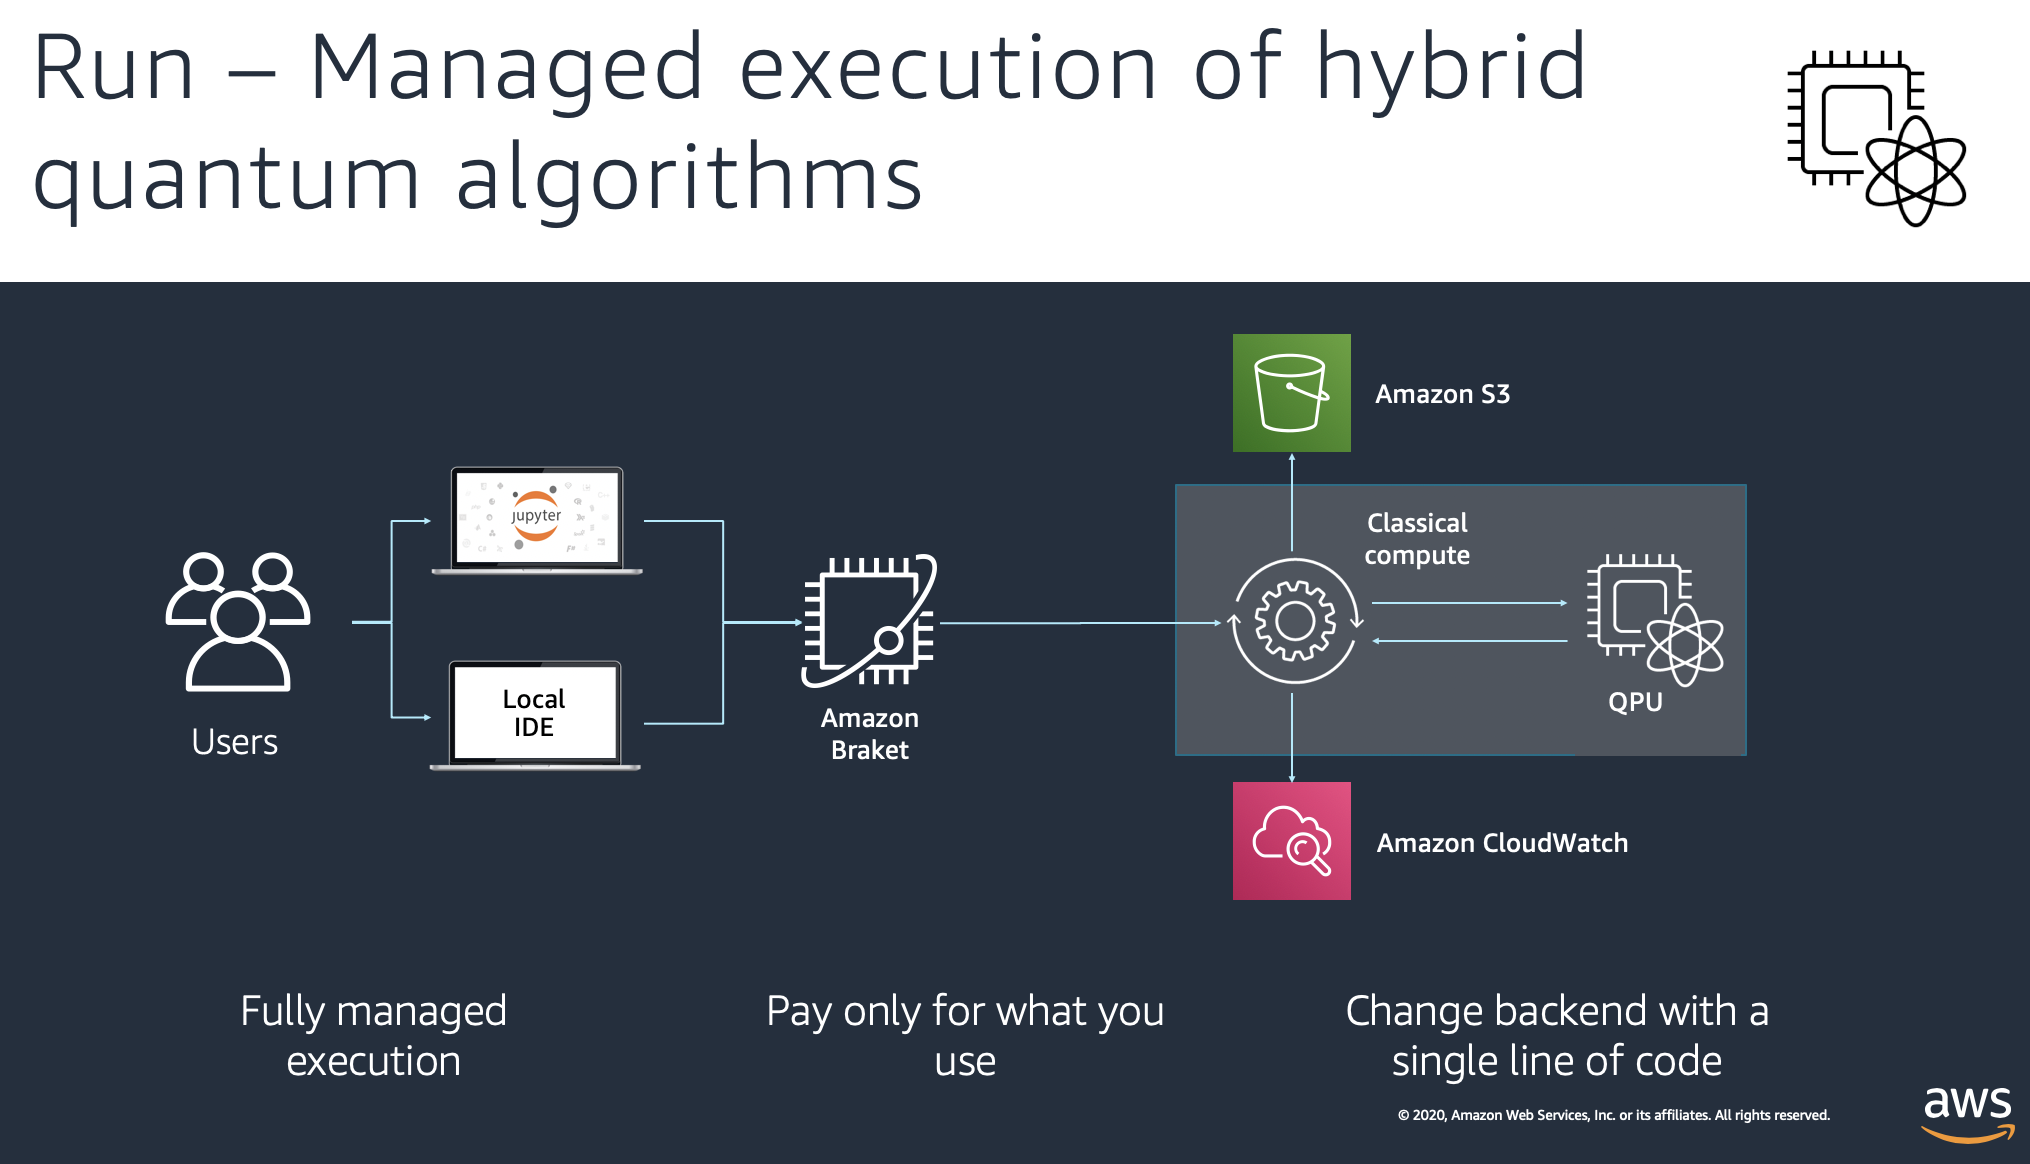

In [1]:
from IPython.display import Image
Image(filename='figures/Braket_Run_scheme.png', width=800, height=800)

__RUN MANAGED HYBRID WORKLOAD__:
- Build quantum algorithms in Jupyter Lab or a local IDE.
- Submit the program together with hardware and backend specifications to the Braket API.
- Select EC2 instance type and configurations for classical part of computation.
- Choose from multiple state-of-the-art simulator or QC backends (for circuit execution).
- Braket will spin up the classical compute and broker the execution between CPU and QPU.
- Pay only for what you use; tear down resources when done. 
- Touchpoints to other AWS services: 
    - All input and output data can be stored in Amazon Simple Storage Service (S3).
    - Logs and custom metrics reported to Amazon CloudWatch. 

## IMPORTS and SETUP

In [2]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
import seaborn as sns
import pickle
import time
import pandas as pd
import json
from datetime import datetime
import tarfile
import os
# from IPython.display import Image

In [3]:
from utils_classical import plot_colored_graph, plot_colored_graph_simple, solve_classical_ising
from utils_qaoa import kickoff_train, postprocess
# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2

In [4]:
# AWS imports
import boto3
from braket.circuits import Circuit 
from braket.aws import AwsQuantumSimulator, AwsSession

__NOTE__: Please enter your desired S3 location (bucket and key) below. 

In [5]:
# setup session
from botocore.session import get_session
creds = get_session().get_credentials()
session = boto3.Session(aws_access_key_id=creds.access_key, aws_secret_access_key=creds.secret_key,
                        aws_session_token=creds.token, region_name="us-west-1")
aws_session = AwsSession(boto_session=session)

# setup device
# device_arn = "arn:aws:aqx:::quantum-simulator:aqx:qs3"
# device = AwsQuantumSimulator(device_arn)

# setup s3 folder
my_bucket = "braket-bravehearts" # enter your bucket here
my_prefix = "simulation-output" # enter your key here
s3_folder = (my_bucket, my_prefix)

## PROBLEM SETUP: BACKGROUND

__QAOA__ designed for QUBO (quadratic unconstrained binary optimization) optimization problems, specifically graph coloring problems (that are generically NP-hard, with exponentialliy increasing solution space). 

__Graph coloring problem__: Given a graph of nodes and edges, goal is to color each node red or blue, then score a point for each node that is next to a node of different color. Find a coloring that scores the most points. 

__Applications__ can be found in: 
- Clustering for marketing purposes (segment your customer base into different clusters for targeted marketing). 
- Portfolio optimization in finance (vertex corresponds to asset, color refers to sell or buy).
- Resource allocation: distribute airplanes over terminals avoiding obverlap conflicts.

We encode the problem as a __minimization problem__ of an __Ising Hamiltonian__, where the cost function reads $$H_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z}.$$

## MANAGED JOB

In the following we walk through the essential steps for running a managed job on Amazon Braket. These are: (0) Setup our problem, (1) upload problem to S3, (2) package code into single .py file ready for managed job. Upload script to S3 as well, and (3) submit managed job with simple ```create_quantum_job()``` API call. 

### Managed Job with ```boto3``` API CALL

__Step 0__: Setup problem on graph. 

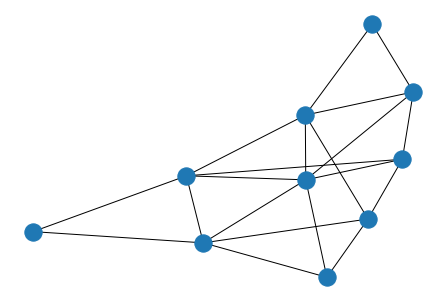

In [6]:
# setup Erdos Renyi graph
n = 10  # 10 nodes
m = 20  # 20 edges

# G = nx.gnm_random_graph(n, m)
G = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(G)

# print edges
# print(list(G.edges));

# draw graph
nx.draw(G, pos)
plt.show()

In [7]:
# set Ising matrix 
Jfull = nx.adjacency_matrix(G).todense()
Jfull = np.array(Jfull)
N = Jfull.shape[0]

# get upper triangular matrix
J = np.zeros((N, N))
for ii in range(0, N):
    for jj in range(ii+1, N):
        J[ii][jj] = Jfull[ii][jj]
# print('Ising matrix:\n', J)

__Step 1__: Upload problem (graph) to S3. 

In [8]:
# store Ising matrix locally w/o header and index as CSV file
data_ising = pd.DataFrame(J)
filename_train = './data_local/data_ising.csv'
data_ising.to_csv(filename_train, header=False, index=False)

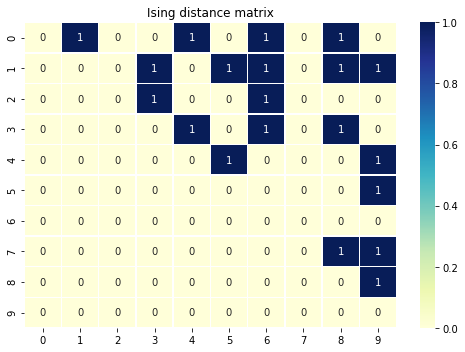

In [9]:
# plot Ising matrix
plt.figure(figsize=[7, 5])
sns.heatmap(data_ising, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();

In [10]:
# helper function to upload to S3
def upload_file(file_name, bucket, object_name=None):
    """
    Upload a file to an S3 bucket
    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = session.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

__NOTE__: Please enter your desired S3 location (bucket and key) below. 

In [11]:
# upload Ising matrix to S3
bucket = 'hybrid-job-mjas' # enter your bucket here
s3_filename = 'data/data_ising.csv' # enter your filename here
upload_file(filename_train, bucket, s3_filename)

True

__STEP 2__: Package code into single .py file ready for managed job where user can define underlying hardware in API call. Upload script to S3. 

In [12]:
# local IDE: show training job script for managed job (use ‘! more’ on Windows)
! cat qaoa_braket.py

#!/usr/bin/python3

# A sample program that runs QAOA using the Braket SDK

from __future__ import print_function
import os
import json
import pickle
import sys
import traceback
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import time

# AWS imports
import boto3
from braket.circuits import Circuit
from braket.aws import AwsQuantumSimulator, AwsSession, AwsQpu, AwsQuantumTask, AwsQuantumSimulatorArns, AwsQpuArns
from botocore.session import get_session


########################
# CONTAINER PATH SETUP #
########################

# Braket file directory
prefix = '/opt/ml/'

# Data location
input_path = prefix + 'input/data'
param_path = os.path.join(prefix, 'input/config/hyperparameters.json')  # Passed parameters can be retrieved here
output_path = os.path.join(prefix, 'output')  # Failure output & error messages should be written here

# Model Results
model_path = os.path.join(prefix, 'model')  # All results should be written here

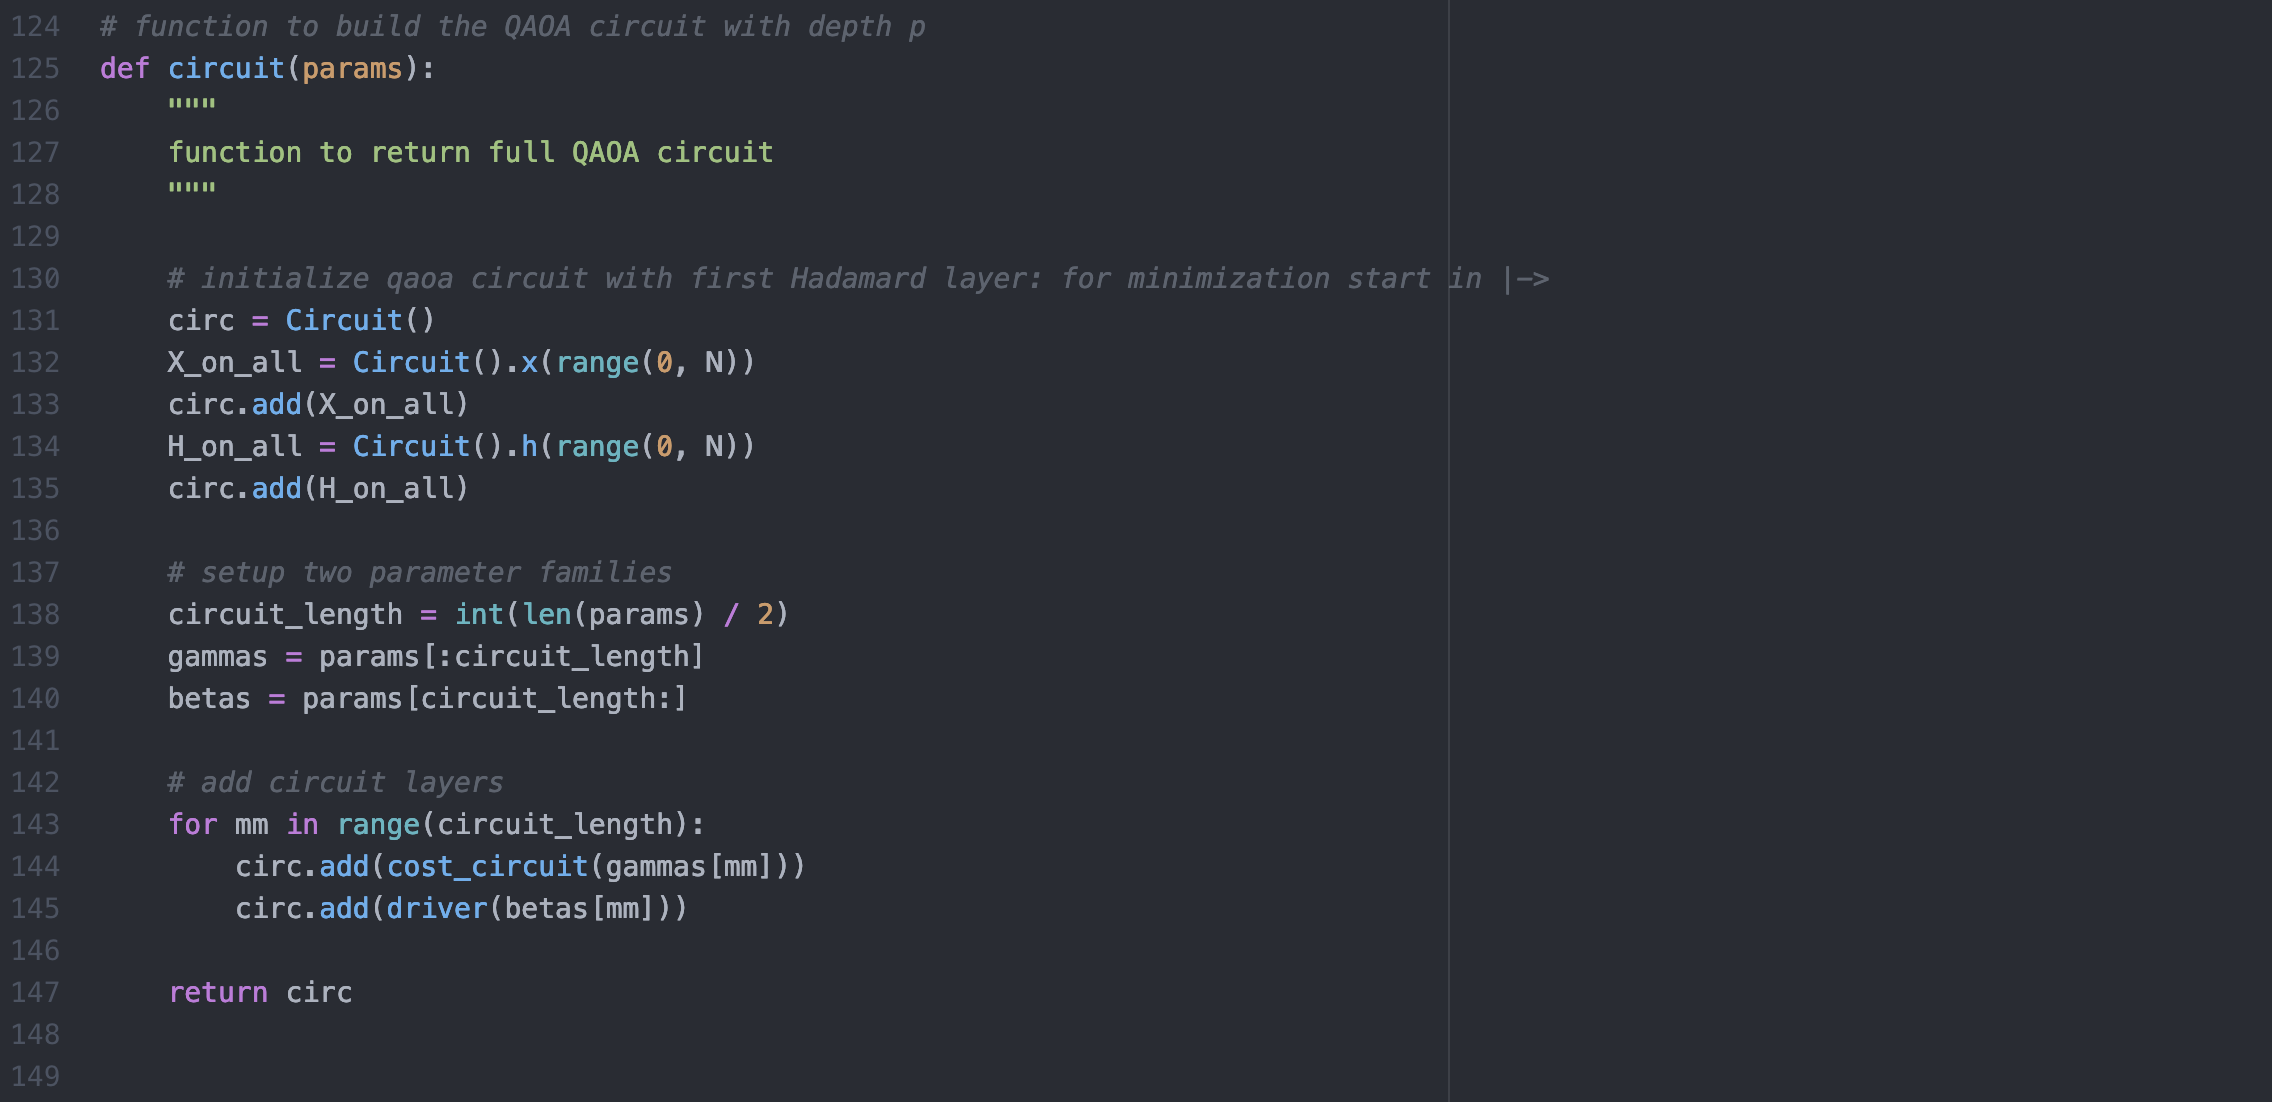

In [13]:
Image(filename='figures/script3.png', width=700, height=700)

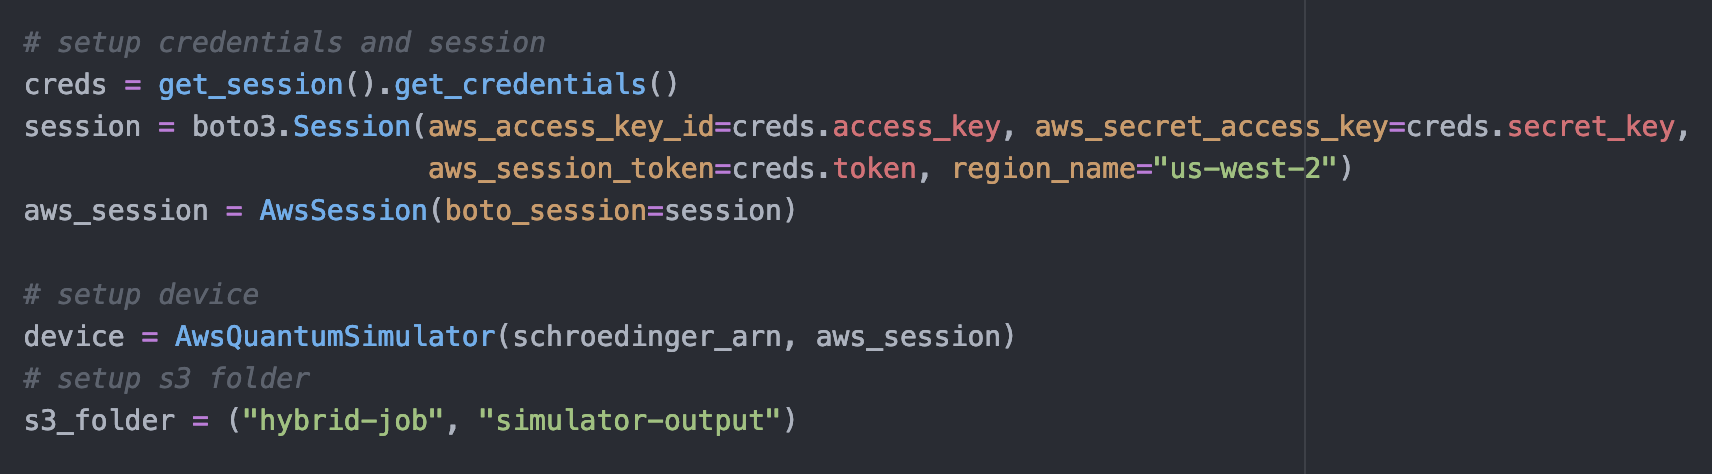

In [14]:
Image(filename='figures/script6.png', width=700, height=700)

__NOTE__: Changing to QPU (```device=...```) means changing one line of code here. 

In [15]:
# upload training script to s3
upload_file('qaoa_braket.py', bucket, 'qaoa_braket.py')

True

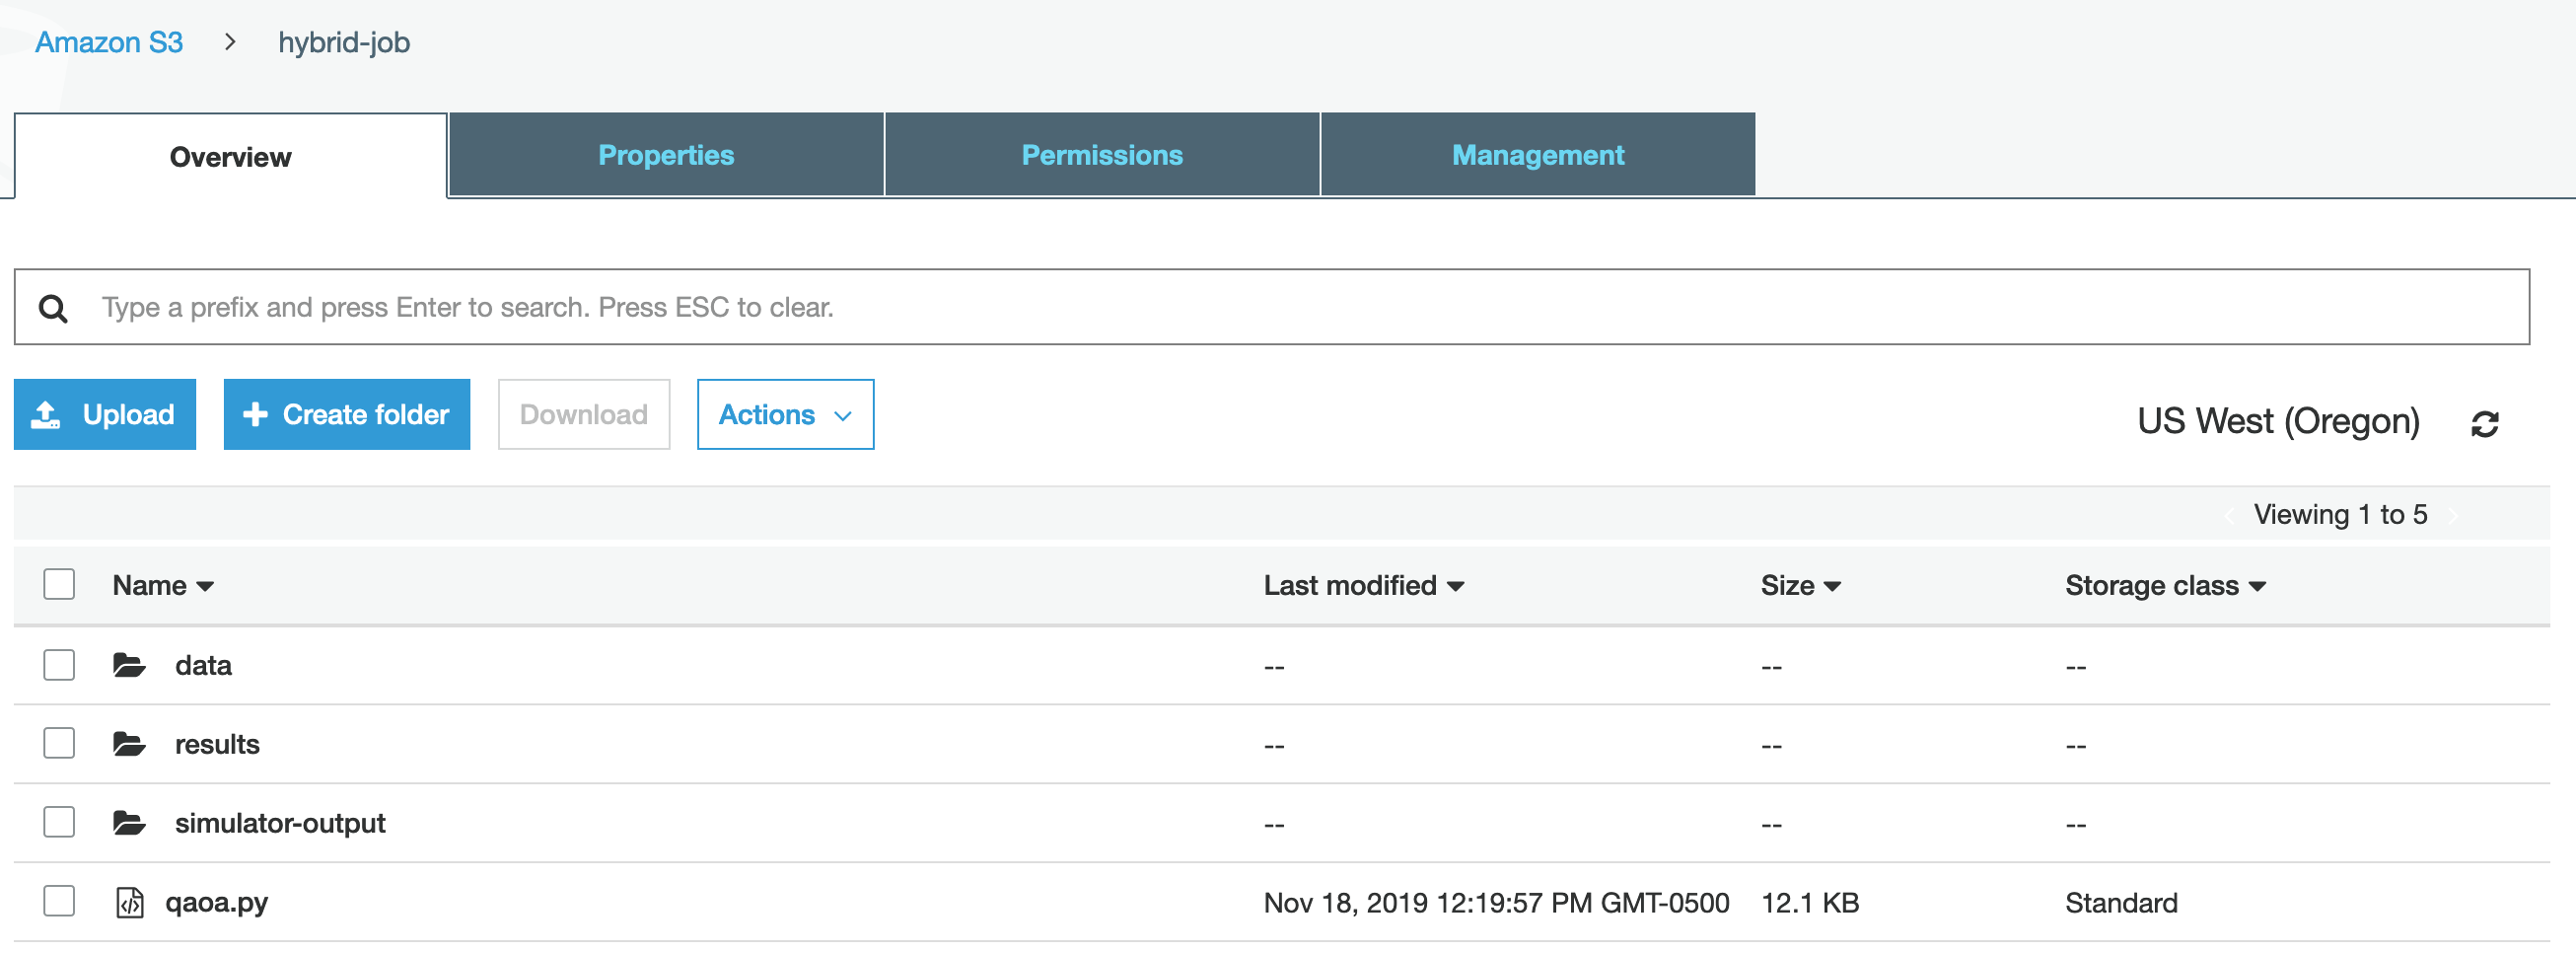

In [16]:
# screenshot from S3 location
Image(filename='figures/script_s3.png', width=800, height=800)

__Step 3__: Submit managed job specifying ```hardware``` in API call and pointing to the __S3 location__ where script with instructions is located. Customer can also define ```stoppingCondition``` and custom metrics to be tracked by __CloudWatch__. Hybrid algorithms executed by Amazon Braket service as managed jobs can automatically export metrics to Amazon CloudWatch. 

To export metrics to Amazon CloudWatch: 
1.	Decide the metrics that you want to emit. This can be done while writing the hybrid algorithm.
2.	Decide the format that the generated metrics will take.
Metrics will be automatically pushed to Amazon CloudWatch. 

In [17]:
# setup client
braket_client = aws_session.braket_client

In [18]:
# run training job tagged with custom job name
project_name = 'qaoa'
job_name = project_name+'-'+datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print('jobName with time stamp:', job_name)

jobName with time stamp: qaoa-20200401203511


In [19]:
# call API
my_role = "arn:aws:iam::465542368797:role/AmazonBraketJobExecutionRole" # enter your execution role here
output_path = "s3://hybrid-job-mjas/results" # enter your output path here
hardware = "ml.m4.xlarge"
my_python_script = "qaoa_braket.py"
circuit_depth = 3

quantum_job = braket_client.create_quantum_job(
    jobName=job_name,
    resourceConfig={                         # the classical part of the computation runs 
        "instanceCount": 1,                  # on a single m4.xlarge instance with 50GB volume size
        "instanceType": hardware,
        "volumeSizeInGb": 50
    },
    outputDataConfig={
        "s3OutputPath": output_path 
    },
    stoppingCondition={
        "maxRuntimeInSeconds": 86400         # the job aborts after 1 day
    },
    sagemakerRoleArn=my_role,
    inputScriptConfig={
        "scriptS3Bucket": bucket,
        "scriptS3ObjectKey": my_python_script
    },
    metricDefinitions = [{                   # We are looking for the custom metric cost_avg which we are catching
        'name': "cost_avg",                  # using regex expressions from stdout. This metric is reported out to 
        'regex': "cost_avg=(.*?);"           # CloudWatch
    }],
    hyperParameters={
        'p': str(circuit_depth),
        },
)

In [20]:
# print quantum Job metadata with date, status code etc.
print(quantum_job)

{'ResponseMetadata': {'RequestId': '859b8573-62e4-46b2-a00b-f5fc1acdbaf1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 02 Apr 2020 00:35:14 GMT', 'content-type': 'application/json', 'content-length': '87', 'connection': 'keep-alive', 'x-amzn-requestid': '859b8573-62e4-46b2-a00b-f5fc1acdbaf1', 'x-amz-apigw-id': 'KVTyIE8nSK4FkAg=', 'x-amzn-trace-id': 'Root=1-5e853340-878ce2a8ae34c5d8ca318e78;Sampled=0'}, 'RetryAttempts': 0}, 'quantumJobArn': 'arn:aws:aqx:us-west-1:465542368797:quantum-job:qaoa-20200401203511'}


In [21]:
# programmatically check the status of job
# corresponding CLI call: aws braket get-quantum-job --quantum-job-arn my_job_arn
quantum_job_arn = quantum_job['quantumJobArn']
job_info = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)
job_status = job_info['jobStatus']

In [22]:
# regulalry check job status
# wait for job to complete
while job_status != 'Completed':
    job_status = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)['jobStatus']
    print('Status:', job_status)
    time.sleep(30)

Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: Completed


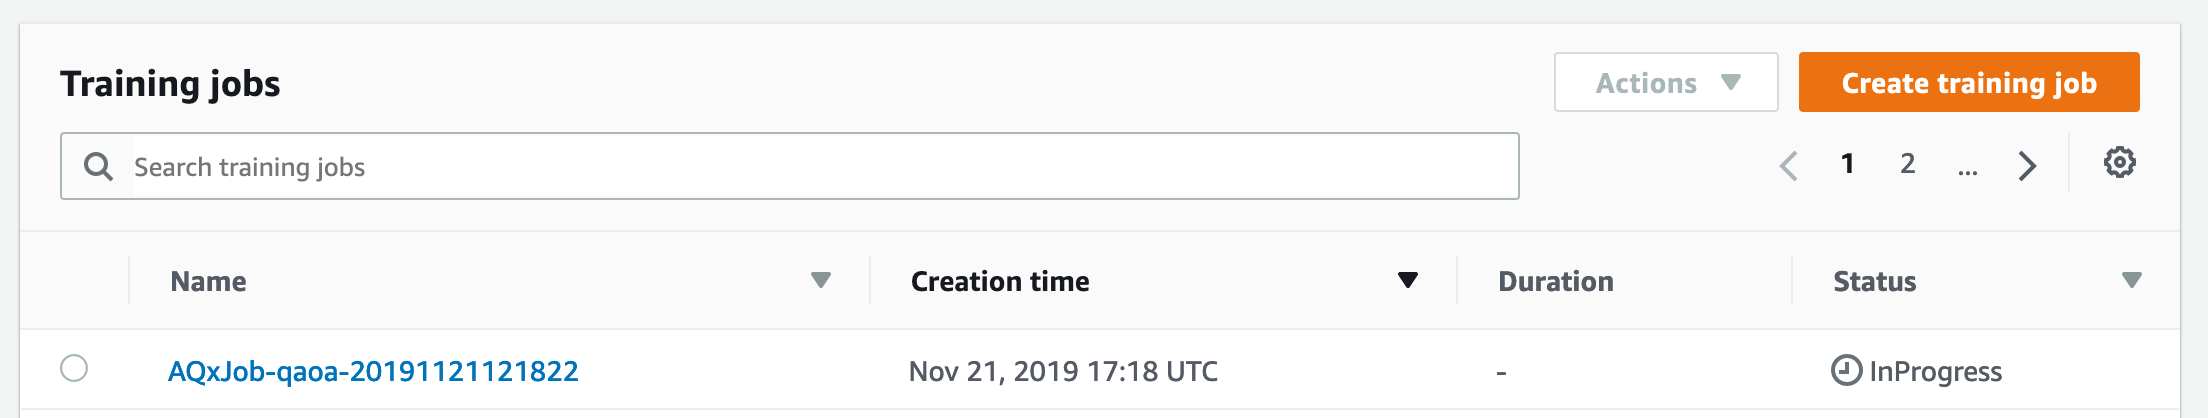

In [23]:
# screenshot from console
Image(filename='figures/job_in_progress2.png', width=1000, height=1000)

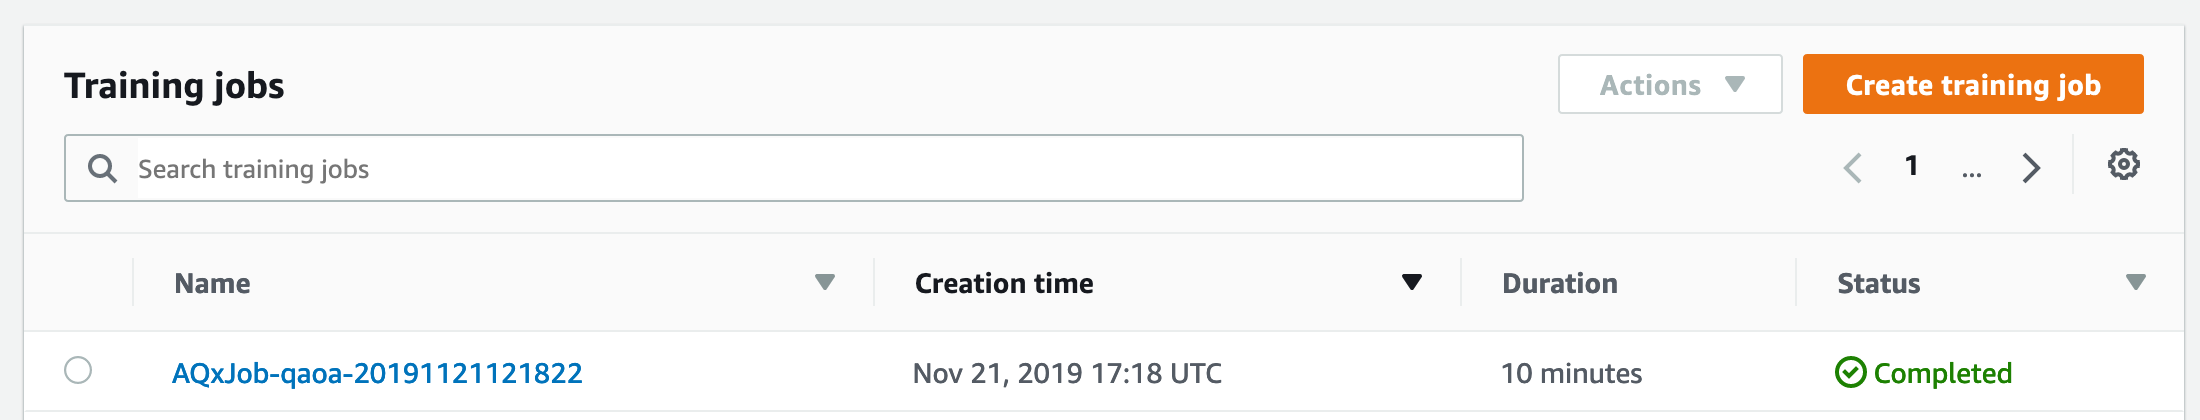

In [24]:
# screenshot from console
Image(filename='figures/job_completed.png', width=1000, height=1000)

### Track Custom Metrics of Managed Job in CloudWatch

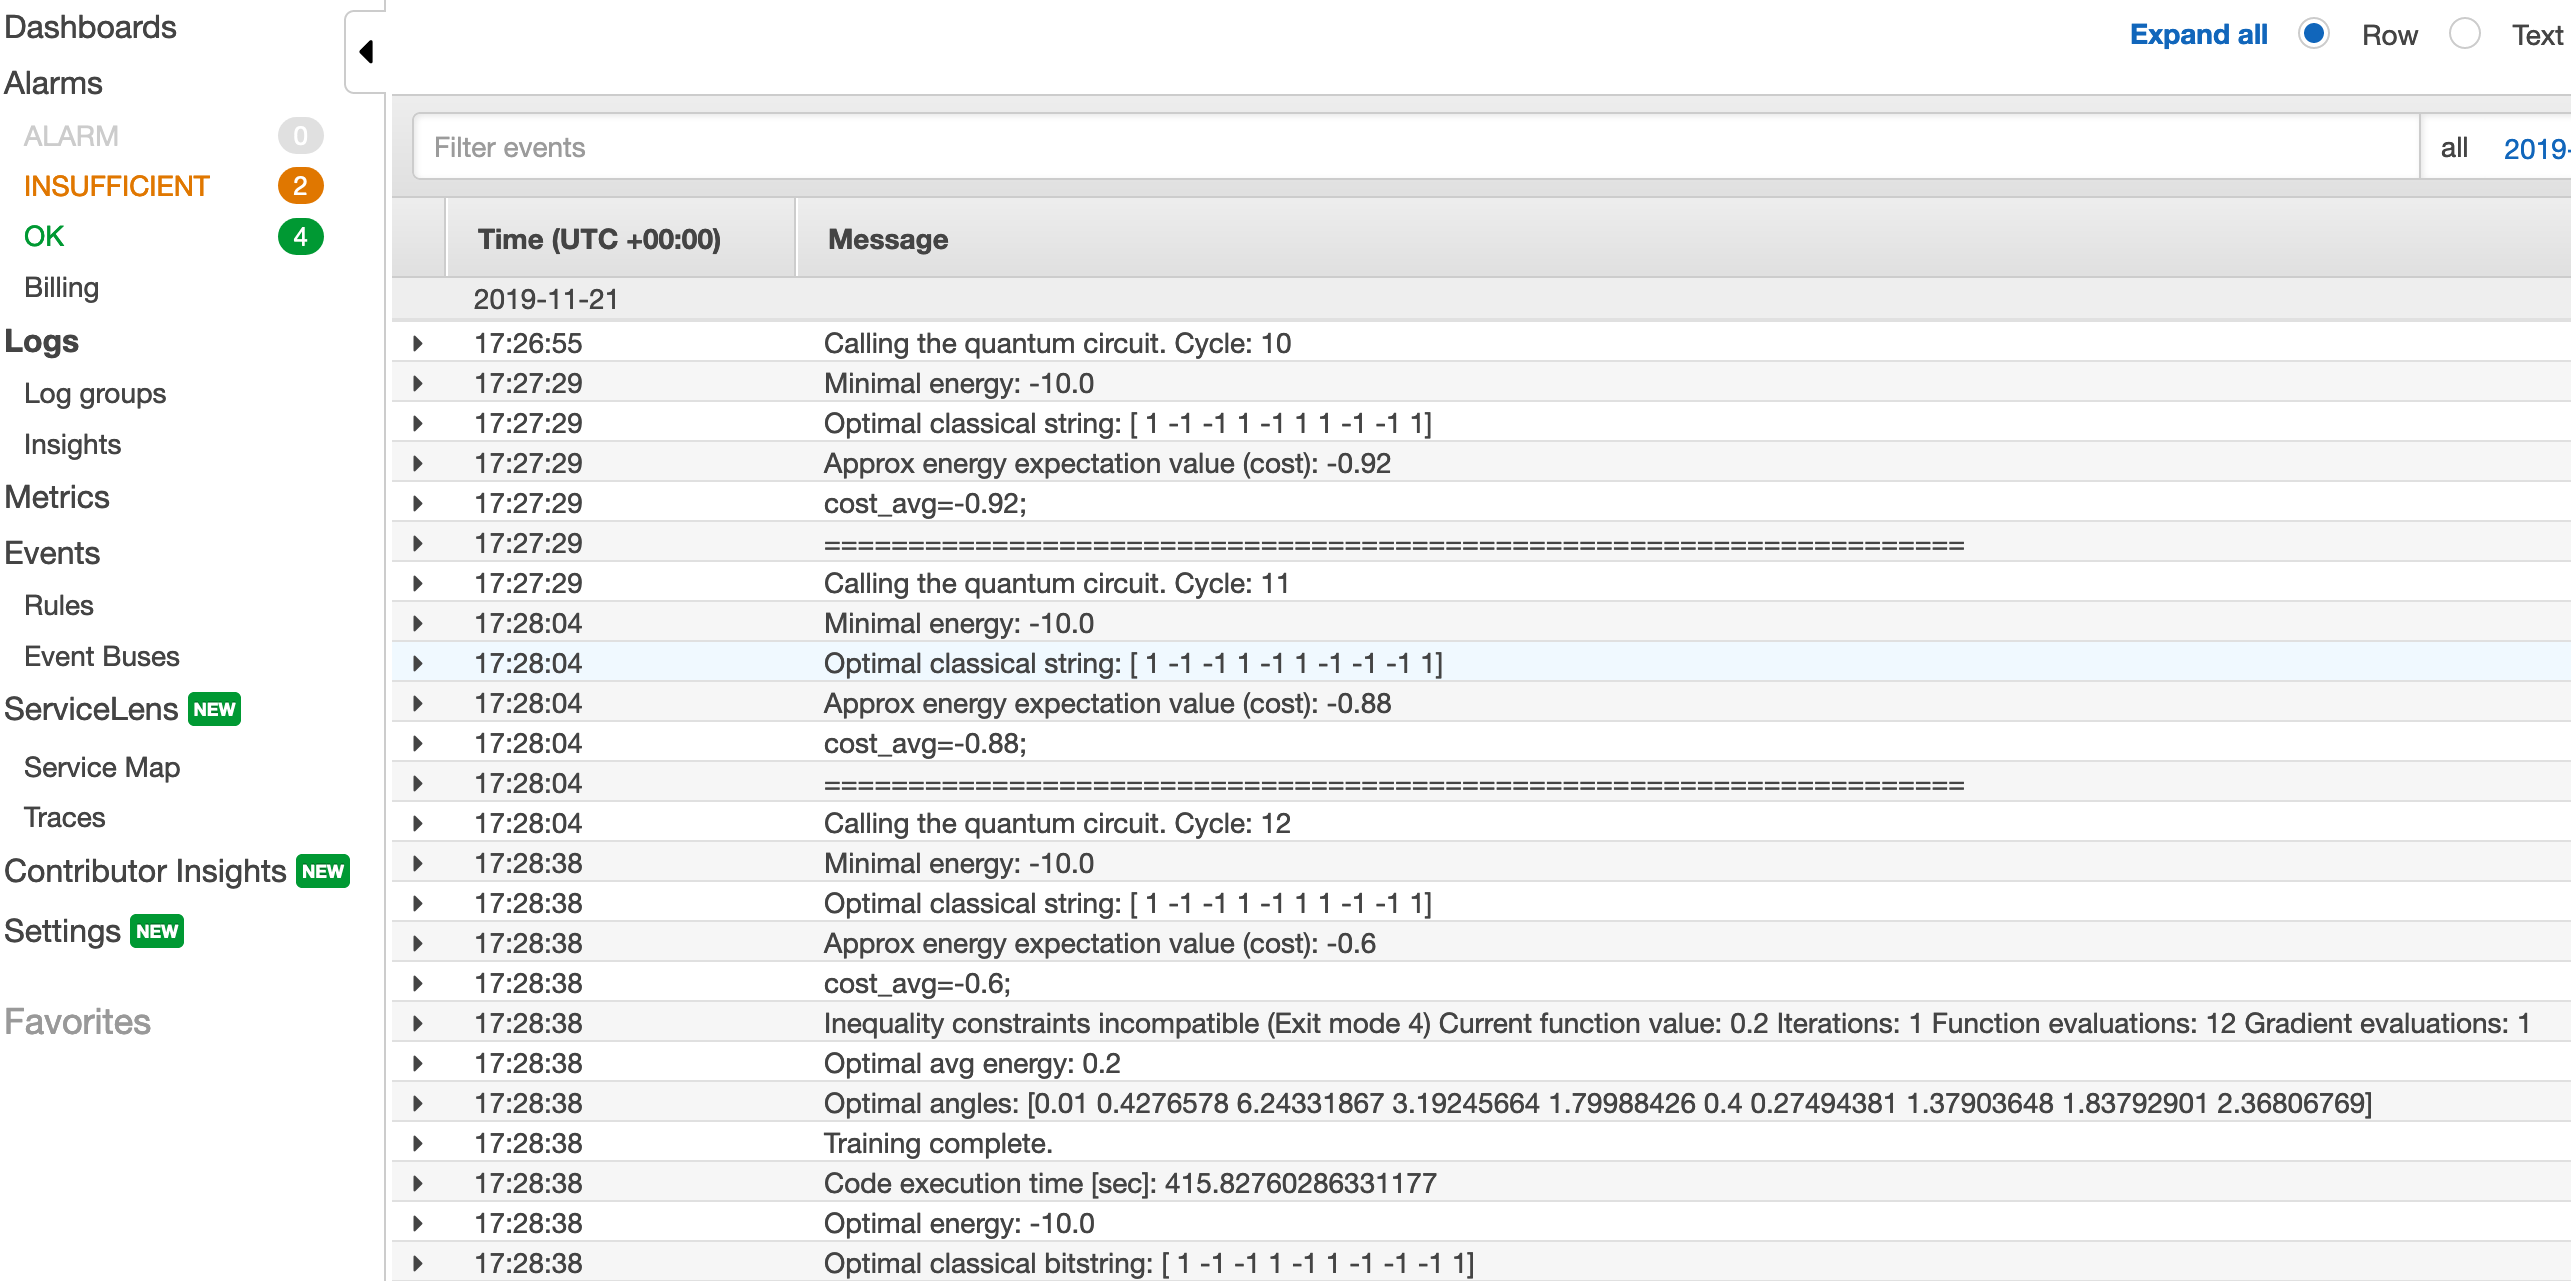

In [25]:
# visualize custome metrics in CloudWatch console
Image(filename='figures/cw_logs.png', width=700, height=700)

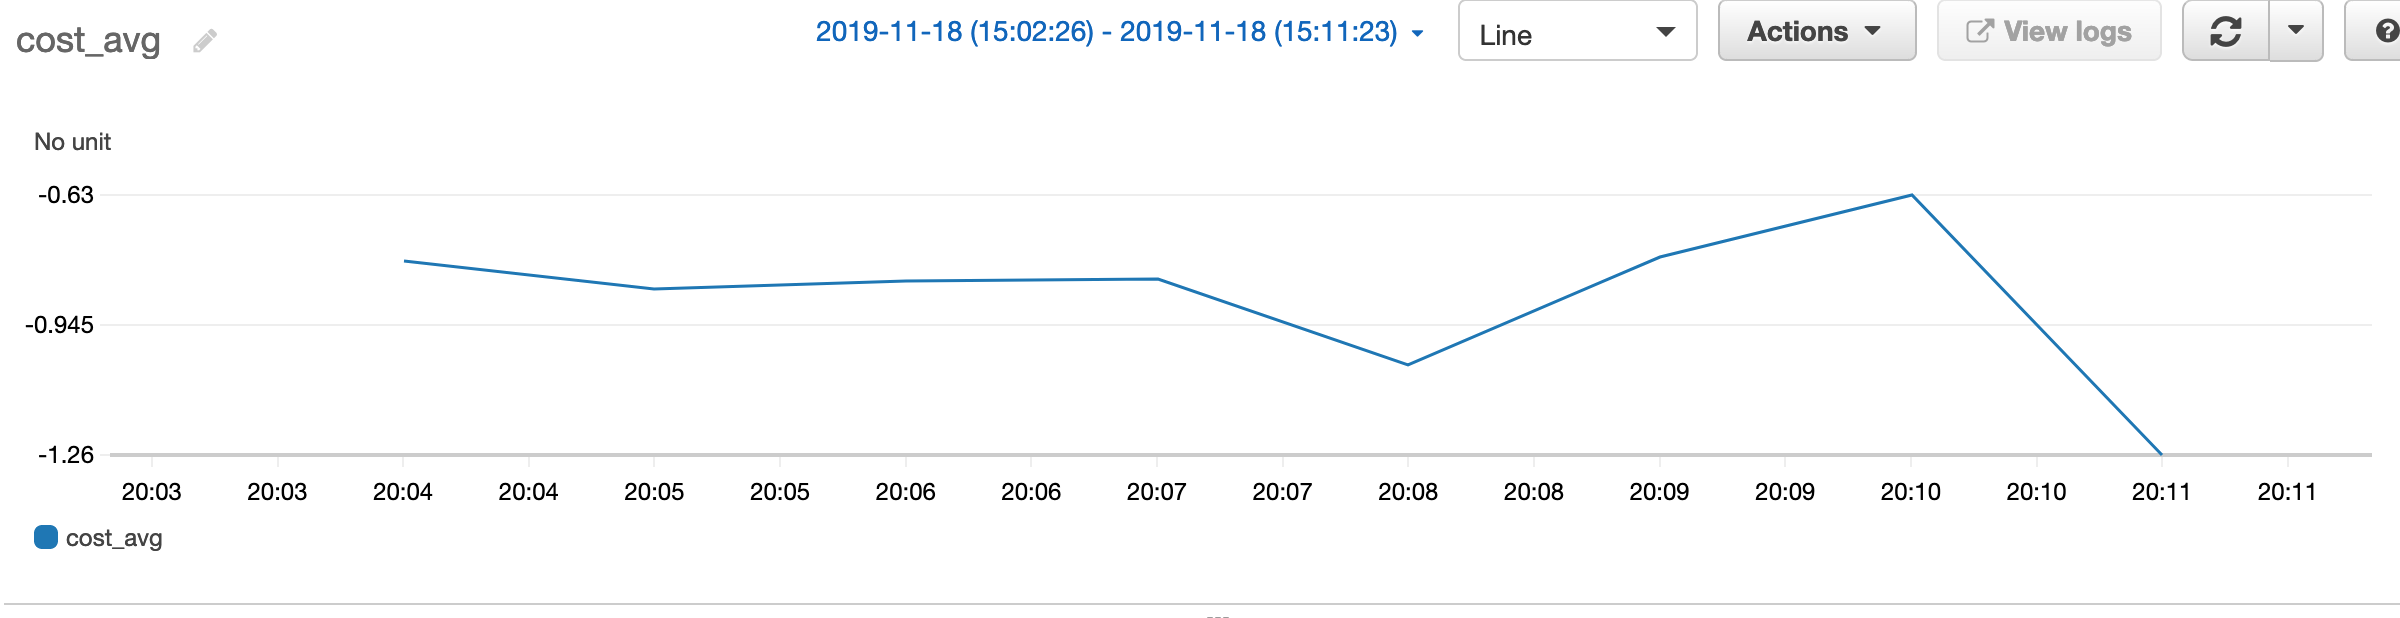

In [26]:
# visualize custome metrics in CloudWatch console
Image(filename='figures/cloudwatch_metric.png', width=1000, height=1000)

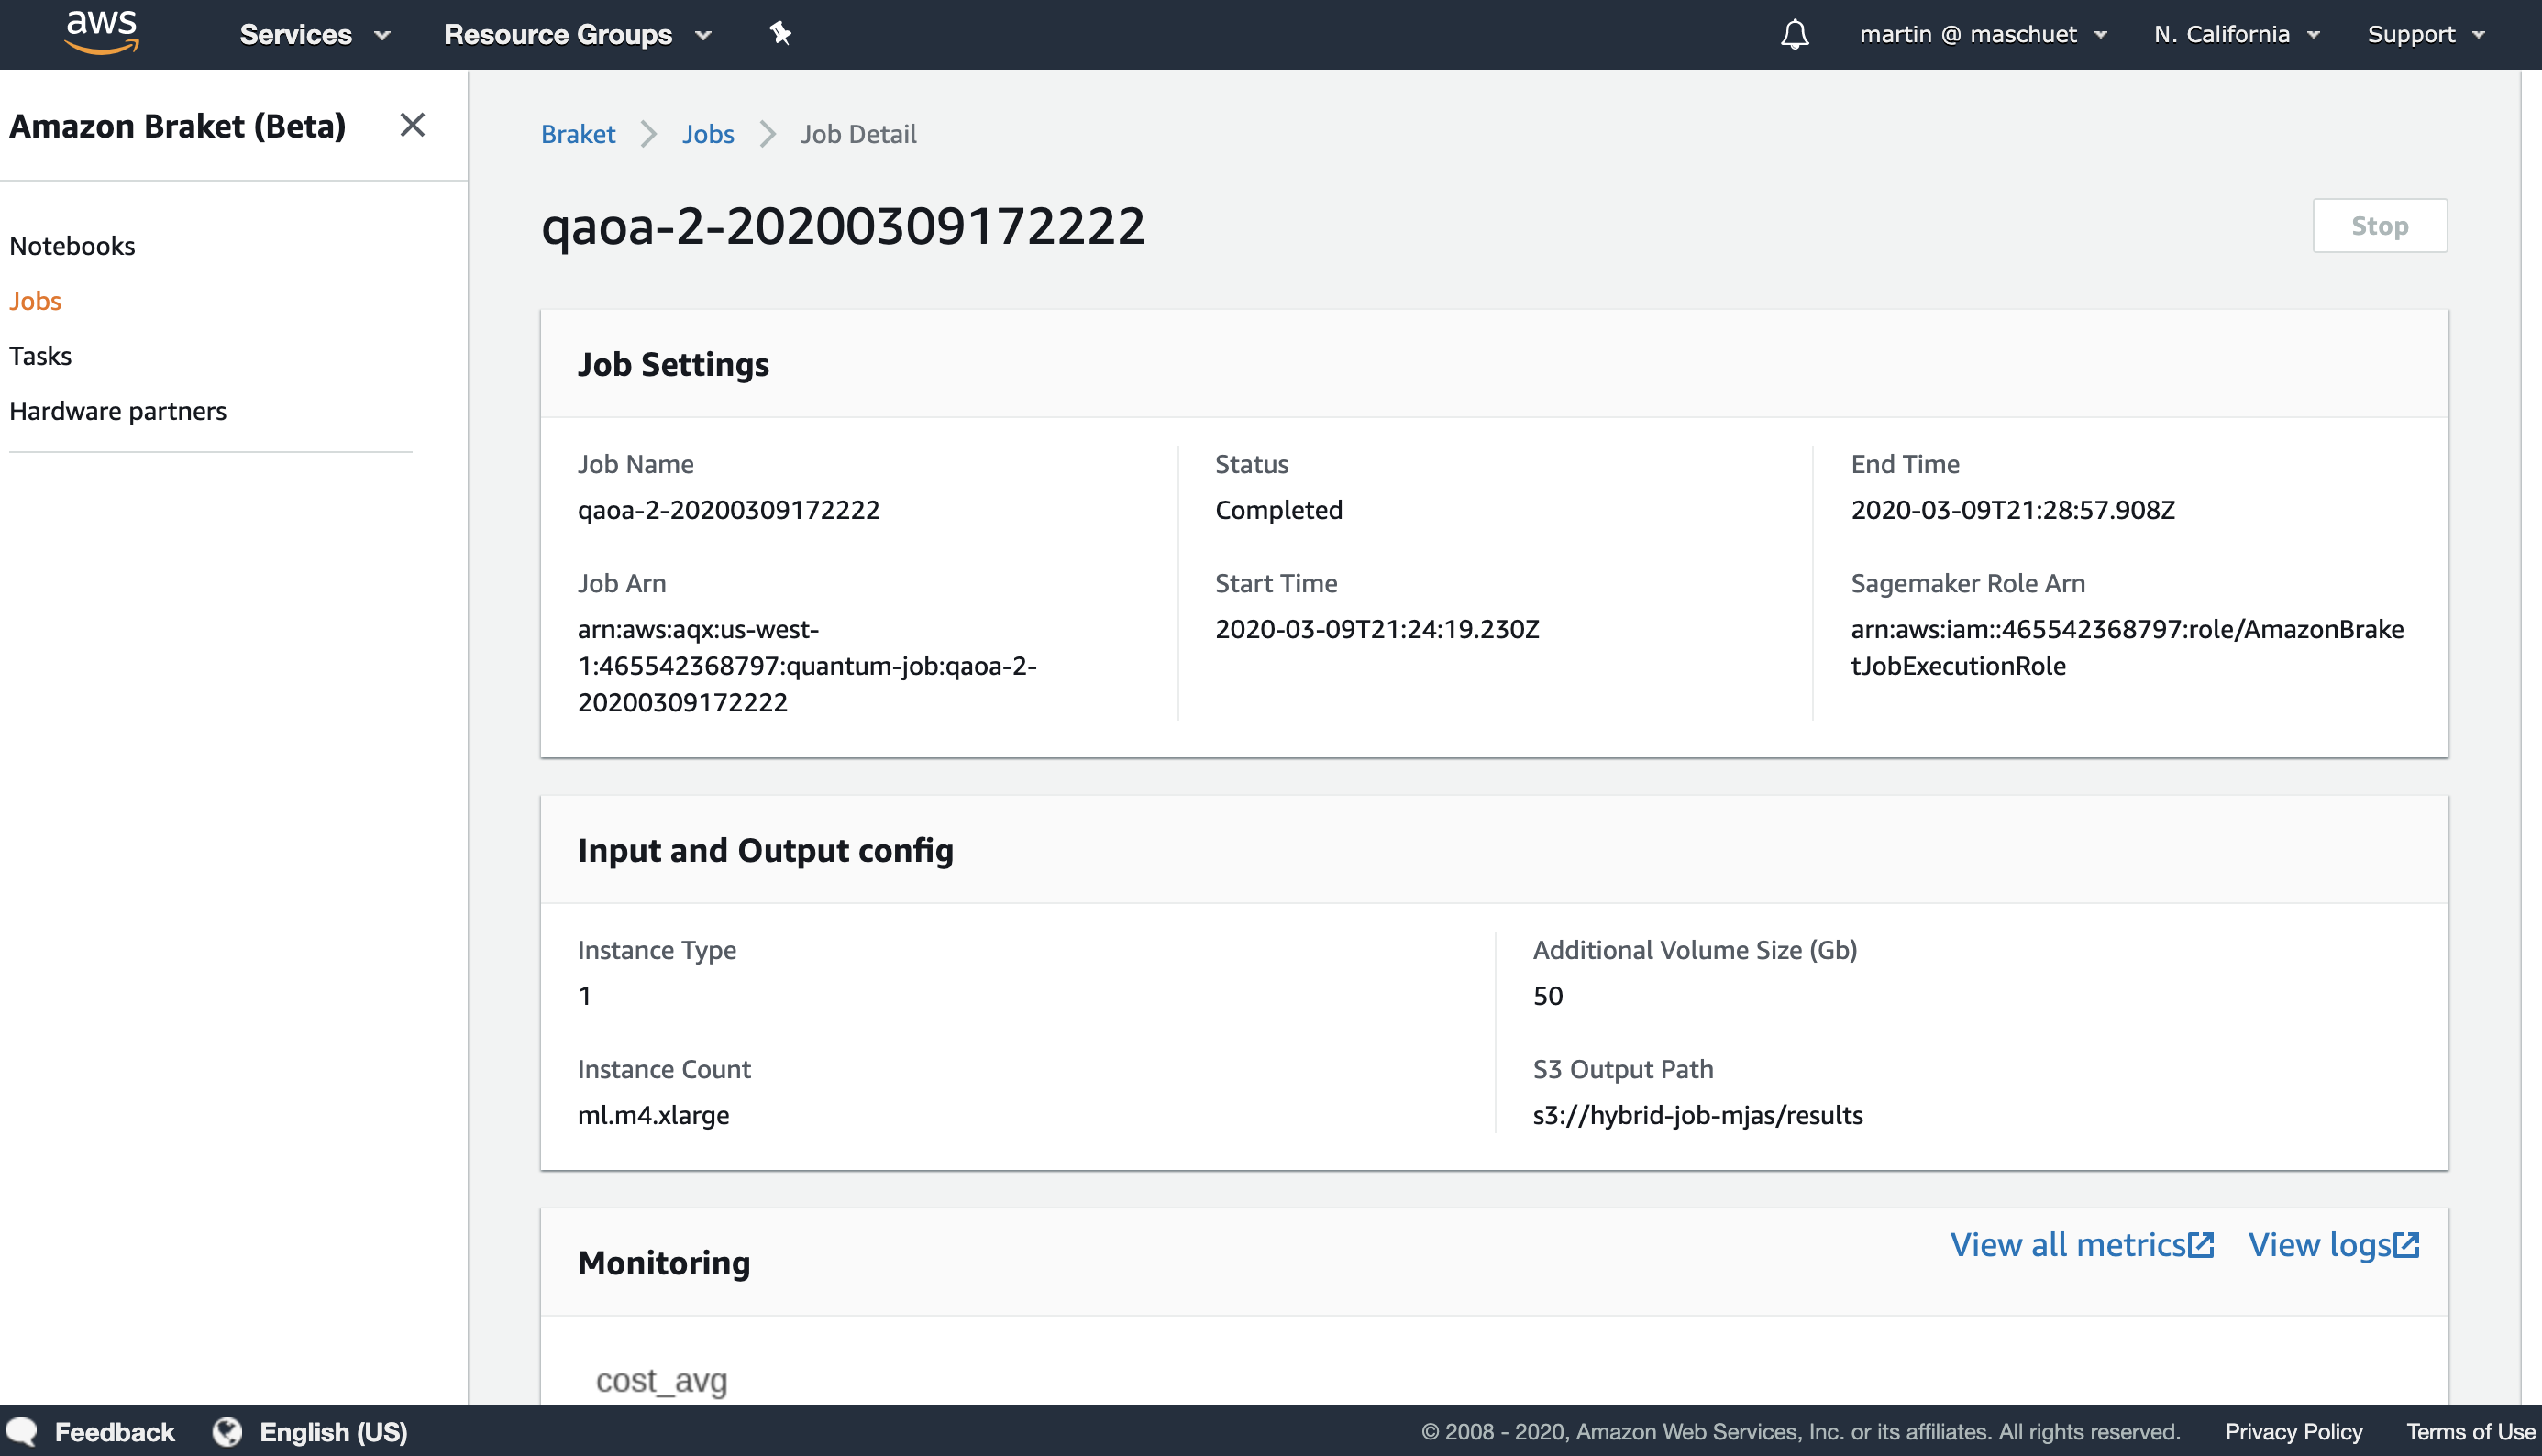

In [27]:
# CloudWatch custom metrics integrated into Braket console 
Image(filename='figures/Braket_console.png', width=800, height=800)

### Visualize Results of Managed Job

Once the managed job is done, results are packed up and stored an S3.

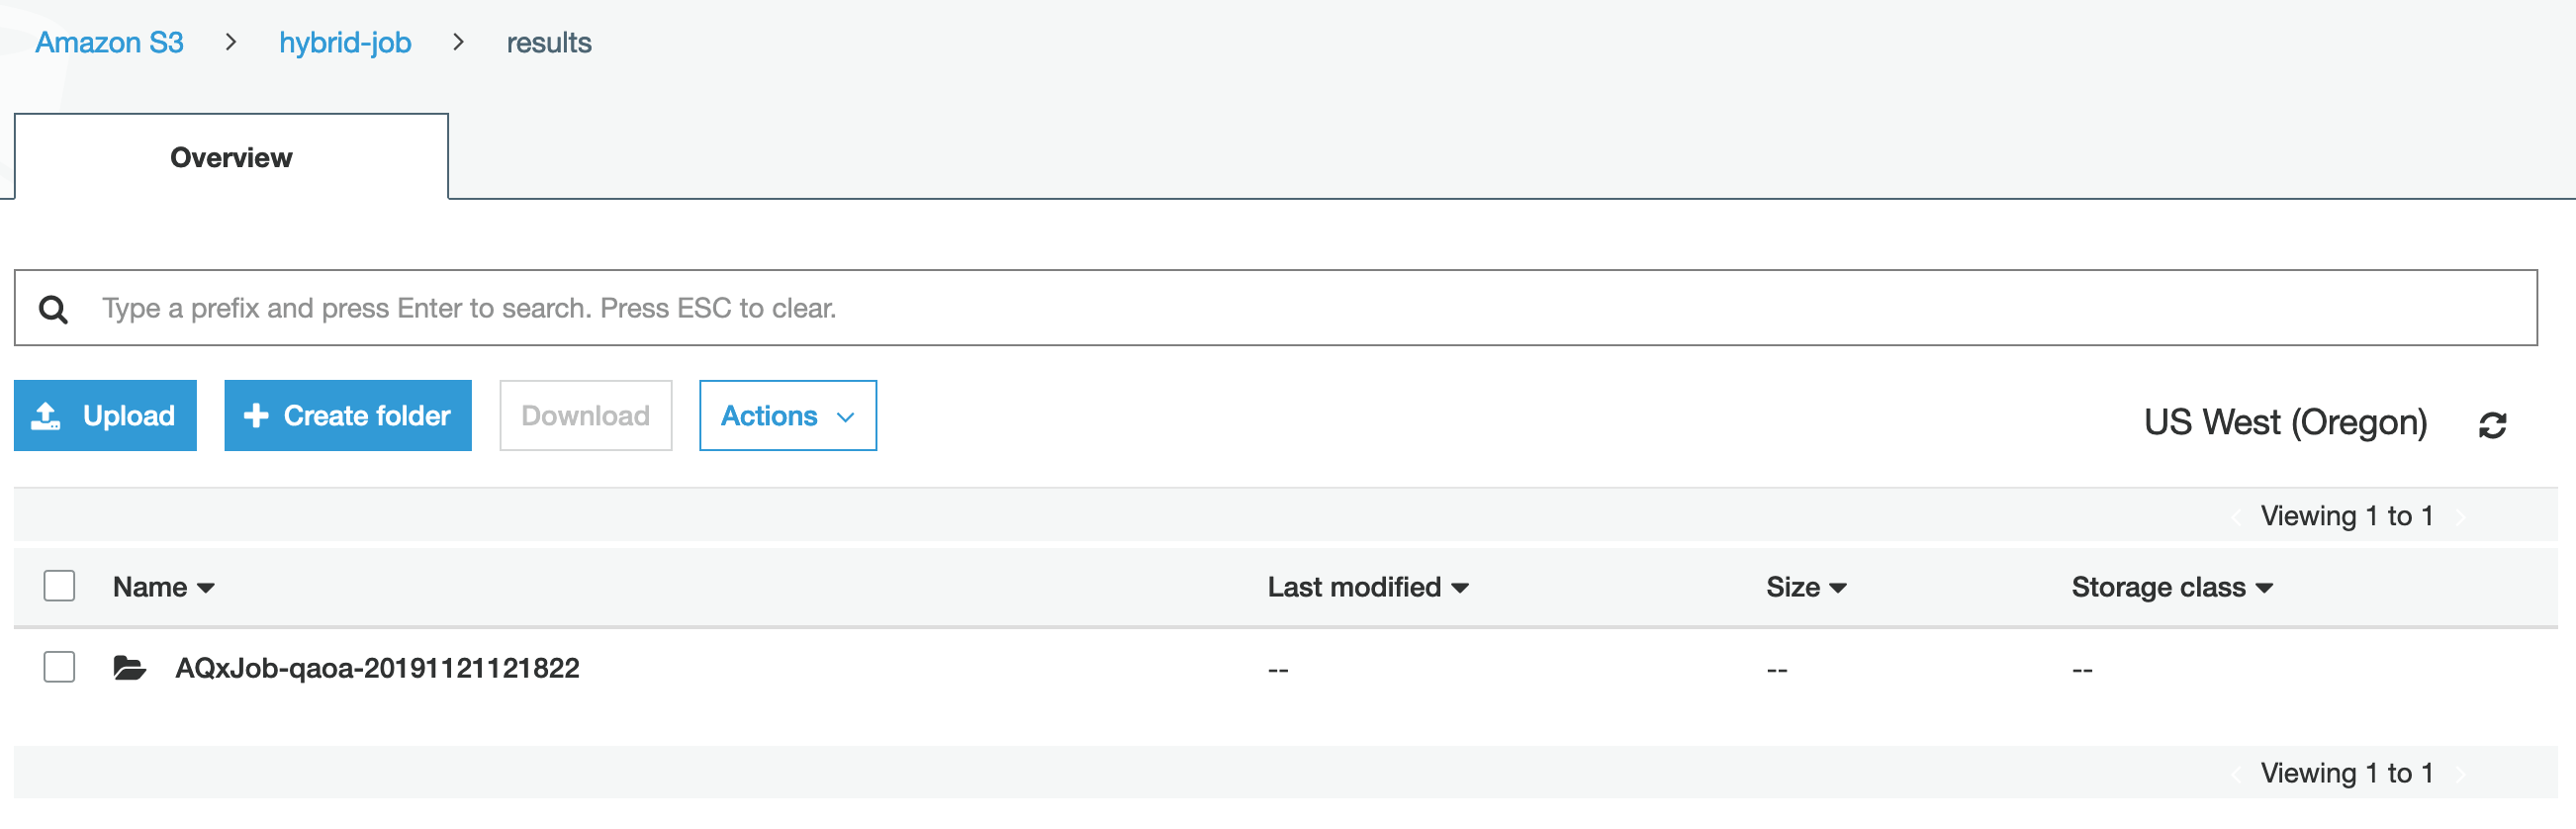

In [28]:
# screenshot from S3 location
Image(filename='figures/results_s3.png', width=800, height=800)

__Step 4__: Retrieve results stored in S3 and analyze and visualize. Enter your bucket below. 

In [29]:
# get the results from S3
# syntax: s3.download_file('BUCKET_NAME', 'OBJECT_NAME', 'FILE_NAME')
object_key = 'results/{}/output/model.tar.gz'.format('AQxJob-'+job_name)
tempfile = '/tmp/model.tar.gz' 
s3_client = session.client("s3")
s3_client.download_file('hybrid-job-mjas', object_key, tempfile) # enter your bucket here

In [30]:
# unzip the results
tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = '/tmp')

# load the results into the notebook
out = pickle.load(open('/tmp/out.pckl', "rb"))

p = out['p']
N = out['N']              
ENERGY_OPTIMAL = out['ENERGY_OPTIMAL']               
BITSTRING = out['BITSTRING']
result_energy = out['result_energy']
result_angle = out['result_angle']

# clean-up temporary files
os.remove(tempfile) 

In [31]:
print('Optimal energy from managed job:', ENERGY_OPTIMAL)
print('Optimal bit-string from managed job:', BITSTRING)

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [-1  1  1 -1  1 -1 -1  1  1 -1]


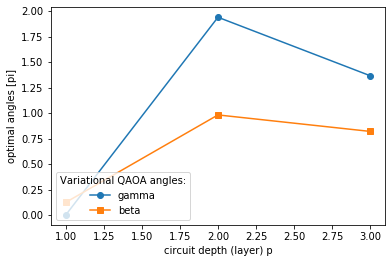

In [32]:
gamma = result_angle[:p]
beta = result_angle[p:]
pa = np.arange(1, p + 1)

fig = plt.figure(2)
plt.plot(pa, gamma / np.pi, '-o', label='gamma')
plt.plot(pa, beta / np.pi, '-s', label='beta')
plt.xlabel('circuit depth (layer) p')
plt.ylabel('optimal angles [pi]')
plt.legend(title='Variational QAOA angles:', loc='lower left')
plt.show()

Minimal energy found from QAOA job: -10.0


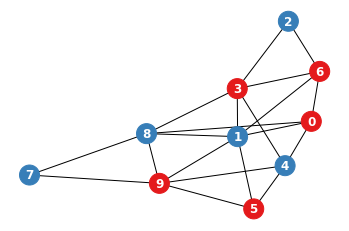

In [33]:
# visualize solution of managed job
colorlist = BITSTRING
colorlist[colorlist == -1] = 0

# plot_colored_graph(J, N, colorlist, pos)
plot_colored_graph_simple(G, colorlist, pos)
print('Minimal energy found from QAOA job:', ENERGY_OPTIMAL)

Classical solution: {'s0': 1, 's1': -1, 's2': -1, 's3': 1, 's4': -1, 's5': 1, 's6': -1, 's7': 1, 's8': -1, 's9': 1}
Minimal energy found classically: -10.0


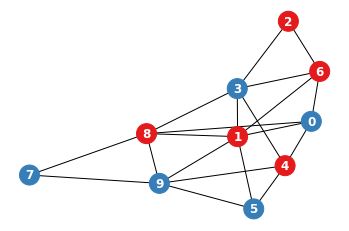

In [34]:
# validate quantum results with classical algorithm
solution, decoded_solution, energy_min, colors_classical = solve_classical_ising(J, N, pos)
# plot classical solution
plot_colored_graph_simple(G, colors_classical, pos)

__NOTE__: In this small toy problem there are many degenerate classical solutions with the same optimal quality. 

### Hyperparameter Optimization (HPO)

Run multiple jobs in parallel for hyperparameter optimization, to speed up the research cycle. 

In [35]:
# upload training script to s3
upload_file('qaoa_hpo.py', bucket, 'qaoa_hpo.py')

True

In [36]:
# kickoff HPO with grid search
jobs = []
circuit_depths = [2, 3, 4]

for pp in circuit_depths:
    print('Starting training with circuit depth', pp)
    jobname = kickoff_train(pp)
    jobs.append(jobname)
    print('=================================='*2)

Starting training with circuit depth 2
jobName with time stamp: qaoa-2-20200401204337
{'ResponseMetadata': {'RequestId': '2fe7ad62-e711-4d88-8679-e1088e60f99a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 02 Apr 2020 00:43:38 GMT', 'content-type': 'application/json', 'content-length': '89', 'connection': 'keep-alive', 'x-amzn-requestid': '2fe7ad62-e711-4d88-8679-e1088e60f99a', 'x-amz-apigw-id': 'KVVBDFf3yK4FqQQ=', 'x-amzn-trace-id': 'Root=1-5e853539-4be17580819a225248e00c48;Sampled=0'}, 'RetryAttempts': 0}, 'quantumJobArn': 'arn:aws:aqx:us-west-1:465542368797:quantum-job:qaoa-2-20200401204337'}
Starting training with circuit depth 3
jobName with time stamp: qaoa-3-20200401204338
{'ResponseMetadata': {'RequestId': '67803357-d0bc-4290-83e8-892570bcbdb7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 02 Apr 2020 00:43:39 GMT', 'content-type': 'application/json', 'content-length': '89', 'connection': 'keep-alive', 'x-amzn-requestid': '67803357-d0bc-4290-83e8-892570bcbdb7', 

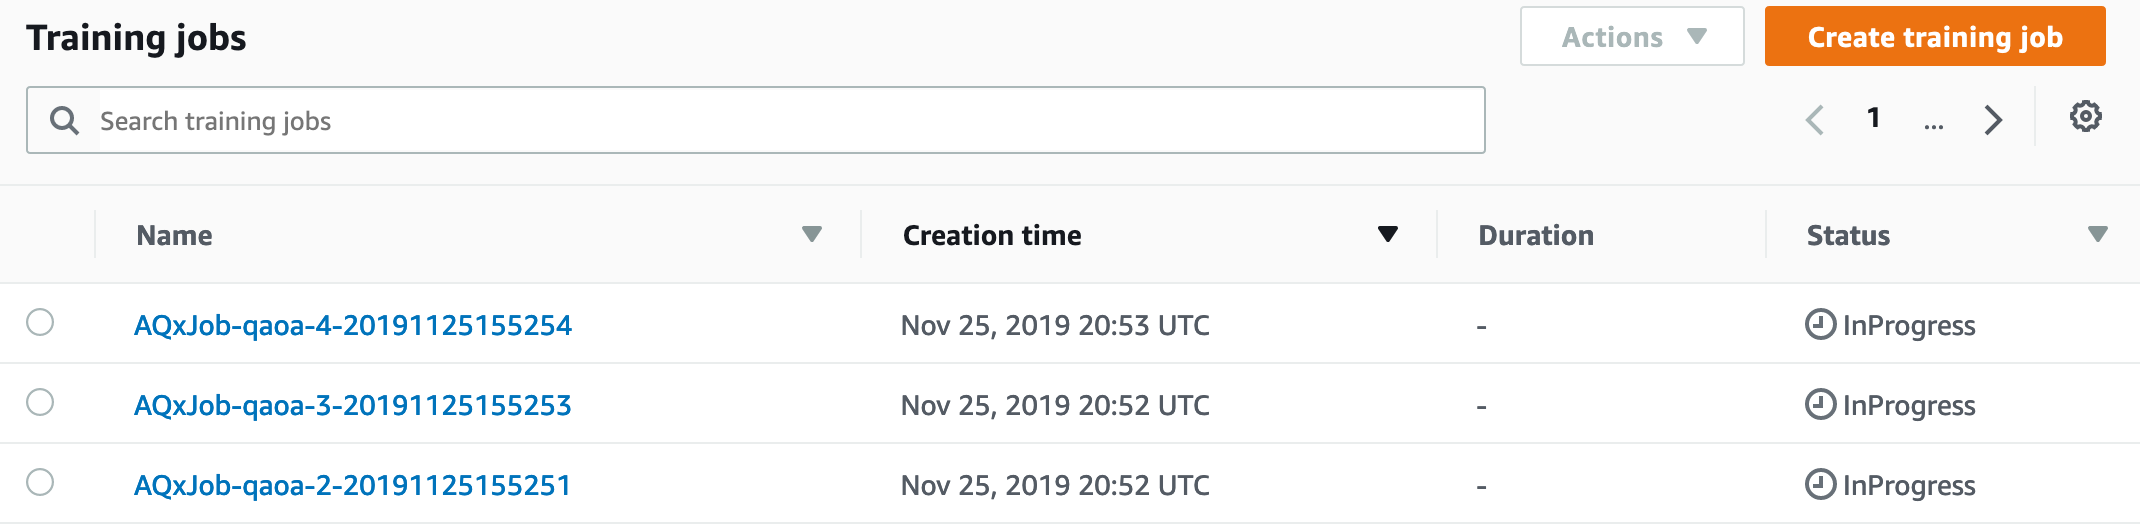

In [37]:
# screenshot from console
Image(filename='figures/jobs_hpo2.png', width=1000, height=1000)

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [-1  1 -1 -1  1 -1  1  1  1 -1]


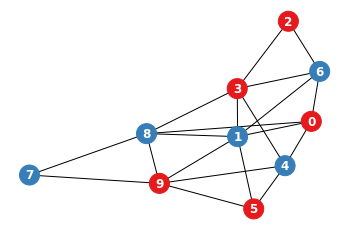

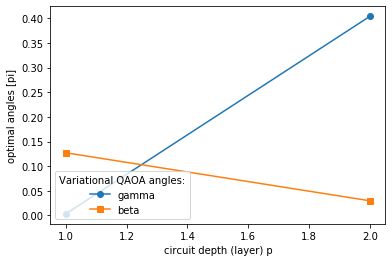

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [ 1 -1  1  1 -1  1 -1  1 -1  1]


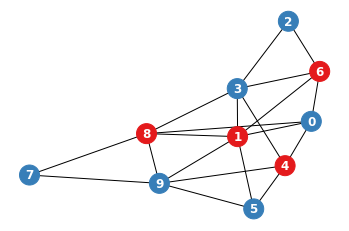

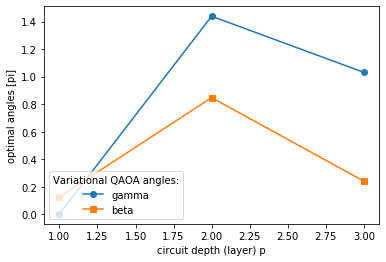

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [ 1 -1  1  1 -1  1 -1 -1 -1  1]


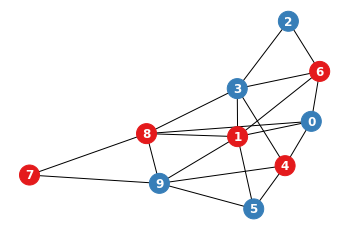

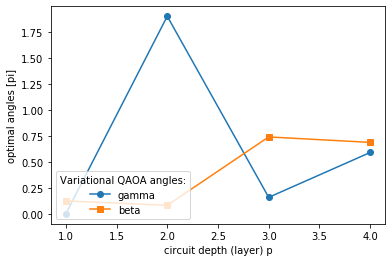

In [38]:
# postprocess results (TODO: add waiter)
for job in jobs:
    # obtain results 
    p, N, ENERGY_OPTIMAL, BITSTRING, result_energy, result_angle, gamma, beta, pa = postprocess(job)
    
    # plot graph: visualize solution of managed job
    colorlist = BITSTRING
    colorlist[colorlist == -1] = 0
    # plot_colored_graph(J, N, colorlist)
    plot_colored_graph_simple(G, colorlist, pos)
    
    # print optimal parameters
    fig = plt.figure(2)
    plt.plot(pa, gamma / np.pi, '-o', label='gamma')
    plt.plot(pa, beta / np.pi, '-s', label='beta')
    plt.xlabel('circuit depth (layer) p')
    plt.ylabel('optimal angles [pi]')
    plt.legend(title='Variational QAOA angles:', loc='lower left')
    plt.show()

### Managed Job using the CLI

Similarly, we can interact with the Braket APIs using the CLI and submit our simulation job directly from CLI. As with any other AWS service one can interact with them in three ways: (i) Console, (ii) SDK (boto3), or (iii) CLI. 

In [39]:
project_name = 'qaoa-cli'
training_job_name = project_name+'-'+datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print('Running Job:', training_job_name)

Running Job: qaoa-cli-20200401210628


In [40]:
# specify job as python dictionary 
# then write this dic to json file
sm_job = {
    "jobName": training_job_name,
    "sagemakerRoleArn": my_role,
    "inputScriptConfig": {
        "scriptS3Bucket": bucket,
        "scriptS3ObjectKey": my_python_script
    },
    "outputDataConfig": {
        "s3OutputPath": output_path
    },
    "resourceConfig": {
        "instanceType": hardware,
        "instanceCount": 1,
        "volumeSizeInGb": 30,
    },
    "stoppingCondition": {
        "maxRuntimeInSeconds": 86400,
    },
     "metricDefinitions": [{
         'name': "cost_avg",
         'regex': "cost_avg=(.*?);"
    }]
}

In [41]:
# save to JSON 
with open('qaoa_job.json', 'w') as outfile:
    json.dump(sm_job, outfile, indent=4)

In [42]:
! cat qaoa_job.json

{
    "jobName": "qaoa-cli-20200401210628",
    "sagemakerRoleArn": "arn:aws:iam::465542368797:role/AmazonBraketJobExecutionRole",
    "inputScriptConfig": {
        "scriptS3Bucket": "hybrid-job-mjas",
        "scriptS3ObjectKey": "qaoa_braket.py"
    },
    "outputDataConfig": {
        "s3OutputPath": "s3://hybrid-job-mjas/results"
    },
    "resourceConfig": {
        "instanceType": "ml.m4.xlarge",
        "instanceCount": 1,
        "volumeSizeInGb": 30
    },
    "stoppingCondition": {
        "maxRuntimeInSeconds": 86400
    },
    "metricDefinitions": [
        {
            "name": "cost_avg",
            "regex": "cost_avg=(.*?);"
        }
    ]
}

In [43]:
! aws braket create-quantum-job --cli-input-json file://qaoa_job.json --region us-west-1 --endpoint "https://fdoco1n1x7.execute-api.us-west-1.amazonaws.com/V2/"

{
    "quantumJobArn": "arn:aws:aqx:us-west-1:465542368797:quantum-job:qaoa-cli-20200401210628"
}


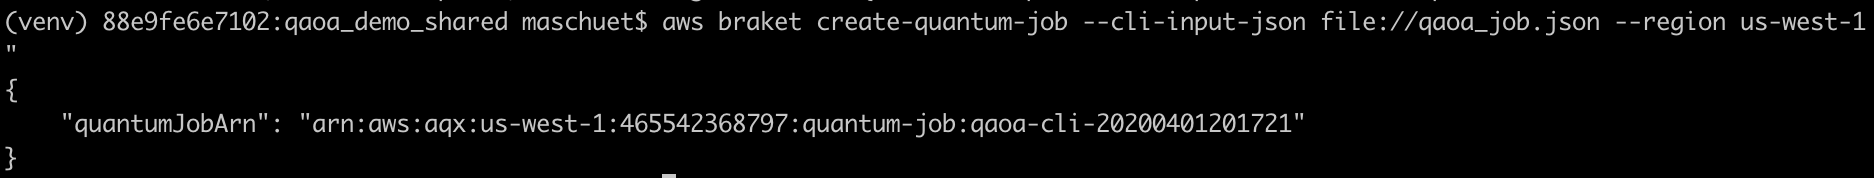

In [44]:
# screenshot of CLI
Image(filename='figures/cli_job.png', width=700, height=700)

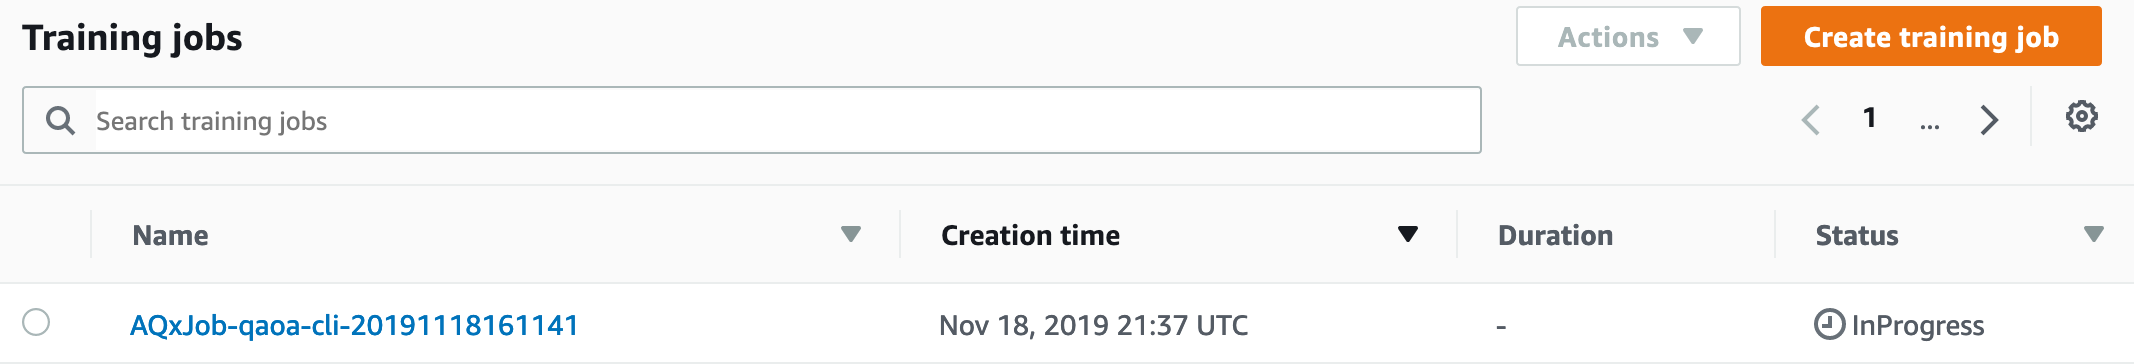

In [45]:
# screenshot from console
Image(filename='figures/job_in_progress_cli.png', width=700, height=700)